### Multi-Variable Data calculation & Visualization

Documentation:\
https://cantera.org/dev/python/thermo.html \
https://cantera.org/dev/examples/python/thermo/equations_of_state.html \
www.coolprop.org/coolprop/HighLevelAPI.html

In [79]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI

In [80]:
gas_ideal = ct.Solution('gri30.yaml',thermo='ideal-gas')

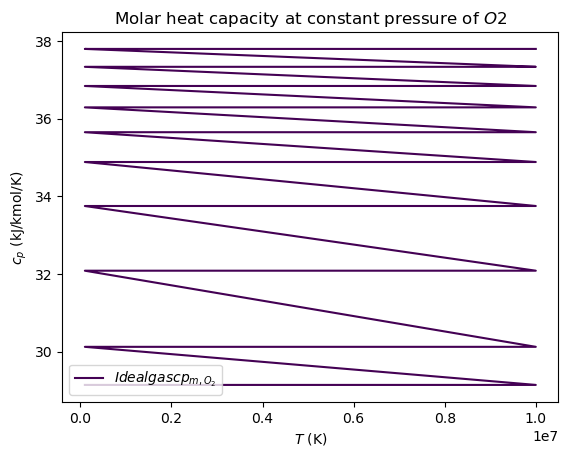

In [81]:
T_list = np.linspace(200, 2000, 10)
p_list = 1e5 * np.linspace(1, 100, 10)  # Pressure is varied from 1 to 100 bar
cp_m_O2ideal_list = []
for T in T_list:
    for p in p_list:
        gas_ideal.TP = T, p
        O2ideal = gas_ideal.species(gas_ideal.species_index('O2'))
        cp_m=O2ideal.thermo.cp(T)/1000 # kJ/kmol/K
        cp_m_O2ideal_list.append([T, p, cp_m])
        
results = np.array(cp_m_O2ideal_list)
plt.plot(results[:, 1], results[:, 2], label='$Idealgas cp_{m,O_2}$')
plt.xlabel('$T$ (K)')
plt.ylabel('$c_p$ (kJ/kmol/K)')
plt.title('Molar heat capacity at constant pressure of $O2$')
plt.legend()

Something went wrong...

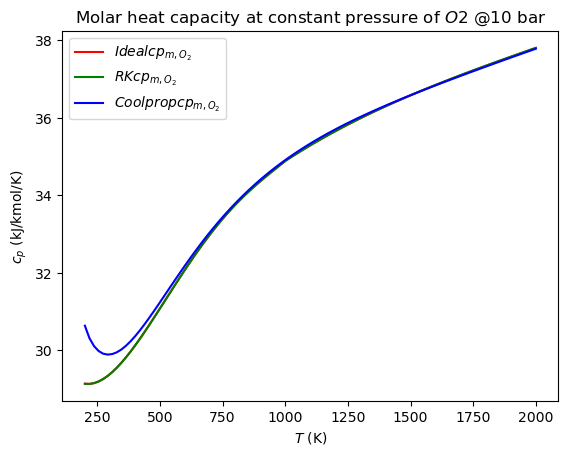

In [82]:
# Now constant p, only varying T

gas_ideal = ct.Solution('gri30.yaml',thermo='ideal-gas')
gas_RK = ct.Solution('gri30.yaml',thermo='R-K')
gas_ideal.TP = 300,1013250
gas_RK.TP = 300,1013250
O2_ideal = gas_ideal.species(gas_ideal.species_index('O2'))
O2_RK = gas_RK.species(gas_RK.species_index('O2'))

T_list = np.linspace(200, 2000, 100)
cp_ideal_list = []
cp_RK_list = []
cp_CoolProp_list = []

for T in T_list:
    cp_m=O2_ideal.thermo.cp(T)/1000 # kJ/kmol/K
    cp_ideal_list.append(cp_m)
    
    cp_m=O2_RK.thermo.cp(T)/1000 # kJ/kmol/K
    cp_RK_list.append(cp_m)

    cp_CoolProp = PropsSI("CPMOLAR", "P", 1013250, "T", T, "O2")
    cp_CoolProp_list.append(cp_CoolProp)

#Plot the results
plt.plot(T_list,cp_ideal_list, label='$Ideal cp_{m,O_2}$', color = 'r')
plt.plot(T_list,cp_RK_list, label='$RK cp_{m,O_2}$', color = 'g')
plt.plot(T_list,cp_CoolProp_list, label='$Coolprop cp_{m,O_2}$', color = 'b')
plt.xlabel('$T$ (K)')
plt.ylabel('$c_p$ (kJ/kmol/K)')
plt.title('Molar heat capacity at constant pressure of $O2$ @10 bar')
plt.legend()

That worked!

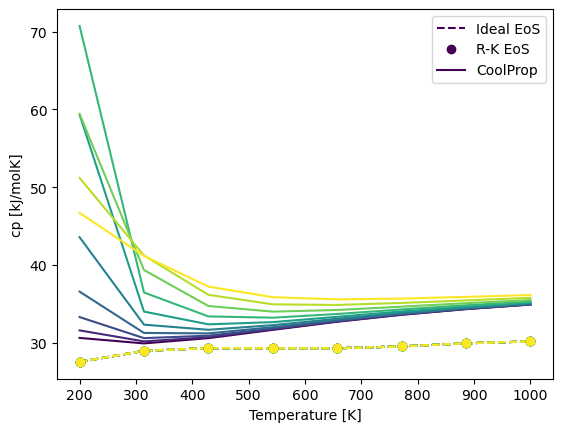

In [83]:
# The following is modified code from
# https://cantera.org/dev/examples/python/thermo/equations_of_state.html

# We are varying T as well as p in size-adjusted arrays

# Input parameters
# Set up arrays for pressure and temperature
p_array = np.logspace(1, np.log10(600), 10, endpoint=True)
T_array = np.linspace(200, 1000, 8)  # Temperature is varied from 200K to 400K
p_array = 1e5 * np.array(p_array)[:, np.newaxis]

# Calculate cp for Ideal gas
ideal_gas_phase = ct.Solution('gri30.yaml',thermo='ideal-gas')
states = ct.SolutionArray(ideal_gas_phase, shape=(p_array.size, T_array.size))
states.TP = T_array, p_array
cp_ideal = states.cp_mole / 1000

#cp for R-K EOS
redlich_kwong_phase = ct.Solution('gri30.yaml',thermo='R-K')
states = ct.SolutionArray(redlich_kwong_phase, shape=(p_array.size, T_array.size))
states.TP = T_array, p_array
cp_RK = states.cp_mole / 1000

#cp in CoolProp
p, T = np.meshgrid(p_array, T_array)
cp_coolprop = PropsSI("CPMOLAR", "P", np.ravel(p), "T", np.ravel(T), "O2")
cp_coolprop = cp_coolprop.reshape(p.shape)

# Plot using cycler
import cycler
color = plt.cm.viridis(np.linspace(0, 1, p_array.size))
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
fig, ax = plt.subplots()
ideal_line = ax.plot(T_array, cp_ideal.T, "--", label="Ideal EoS")
RK_line = ax.plot(T_array, cp_RK.T, "o", label="R-K EoS")
CP_line = ax.plot(T_array, cp_coolprop, "-", label="CoolProp")
ax.set_ylabel("cp [kJ/molK]")
ax.set_xlabel("Temperature [K]")
ax.legend(handles=[ideal_line[0], RK_line[0], CP_line[0]])

#Looking at the plot, this works excellently for CoolProp, but something is going wrong with the Cantera gas Object